# Project Overview
**NMLO Contest 4 - Convolutional Neural Networks**

Brief Description of the Project:-

In this contest you will classify the type of fruit or vegetable in an image using Convolutional Neural Networks (CNNs). You can use deep learning frameworks for this competition.

There are 33 different fruits and vegetables to classify. You will output the String name (not an index from 0-32) for each testing image. All the fruit/vegetable names can be found in the training folder. 
More details on this project can can be found on Kaggle https://www.kaggle.com/c/nmlo-contest-4/overview


## Environment Set up

In [5]:
# usual imports #
import os
import numpy as np
import pandas as pd

# visualization imports #
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

# consistent plots #
from pylab import rcParams
rcParams['figure.figsize']= 12,5
rcParams['xtick.labelsize']= 12
rcParams['ytick.labelsize']= 12
rcParams['axes.labelsize']= 12

# ignore unwanted warnings #
import warnings
warnings.filterwarnings(action='ignore',message='^internal gelsd')

In [12]:
# designate directory to save the images #
ROOT_DIR = '.'
USER_FOLDER = 'MyImages'
IMAGE_DIR = 'Final_Prj_images'

IMAGE_PATH = os.path.join(ROOT_DIR,USER_FOLDER,IMAGE_DIR)
os.makedirs(IMAGE_PATH,exist_ok=True)

In [13]:
# create a function to save the images #
def save_figures(filename,path=IMAGE_PATH,fig_extension='png',tight=True,resolution=300):
    file_path = os.path.join(IMAGE_PATH,filename+'.'+fig_extension)
    plt.savefig(file_path)
    
    if tight:
        plt.tight_layout()
    

## Get the Data 
- The data can be obtained from Kaggle @ https://www.kaggle.com/c/nmlo-contest-4/data
- The downloaded data is under the DATA_PATH @ ***../cloudxlab_jupyter_notebooks/datasets/Kaggle***

In [14]:
DATA_PATH = os.path.join(ROOT_DIR+'.','cloudxlab_jupyter_notebooks/datasets/Kaggle')
TRAIN_PATH = os.path.join(DATA_PATH,'train/train/')
TEST_PATH = os.path.join(DATA_PATH,'test/')

In [5]:
TRAIN_PATH

'../cloudxlab_jupyter_notebooks/datasets/Kaggle/train/train/'

In [6]:
TEST_PATH

'../cloudxlab_jupyter_notebooks/datasets/Kaggle/test/'

In [7]:
# check the files or directories in the training path #
os.listdir(TRAIN_PATH)

['Cantaloupe',
 'Peach',
 'Corn',
 'Lemon',
 'Avocado',
 'Apple Braeburn',
 'Apricot',
 'Pepper Red',
 'Watermelon',
 'Papaya',
 'Cucumber Ripe',
 'Pineapple',
 'Potato Red',
 'Clementine',
 'Cactus fruit',
 'Orange',
 'Cherry',
 'Tomato',
 'Mango',
 'Strawberry',
 'Limes',
 'Onion White',
 'Grape Blue',
 'Passion Fruit',
 'Pepper Green',
 'Pear',
 'Blueberry',
 'Plum',
 'Pomegranate',
 'Kiwi',
 'Banana',
 'Apple Granny Smith',
 'Raspberry']

## Data Exploration 
Select any random directory and view one of the images from the training folder


In [19]:
rand = np.random.randint(len(os.listdir(TRAIN_PATH)))
fruit_title = os.listdir(TRAIN_PATH)[rand]

In [20]:
fruit_path = os.path.join(TRAIN_PATH + fruit_title)
fruit_images  = os.listdir(fruit_path)

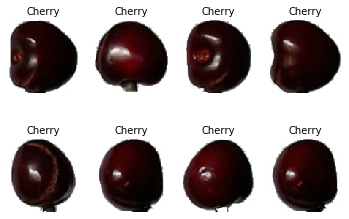

In [21]:
n_rows = 2
n_cols = 4

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows,n_cols,index+1)
        sample_image_path = os.path.join(fruit_path + '/',fruit_images[index])
        fruit = imread(sample_image_path)
        plt.imshow(fruit,cmap='binary',interpolation='nearest')
        plt.axis('off')
        plt.title(fruit_title,fontsize=10)    

Clearly 
- These are colored images of the fruits
- The same fruit can be presented in any orientation and can have varying size
- The brightness varies etc

Hene the model should be good enough to be able to identify the fruit type 
when it is shown in different angles. Fruits also do not have a defined shape and can vary in size
while the overall look would have close resemblance

***Check the number of images in the training folder***

In [22]:
num_images = 0
for folder in os.listdir(TRAIN_PATH):
    num_images = num_images + len(os.listdir(os.path.join(TRAIN_PATH + '/' + folder)))    
print ('Total number of images in the train dir = {}'.format(num_images))

Total number of images in the train dir = 16854


- There are more than 16000 images which can be used to train the model

***Check the dimension of these images***

The data description mentions that the image shape is (100,100,3). However, we will confirm this to avoid surprises. 

In [23]:
# check the dimension of each training image #
dim1 = []
dim2 = []

for folder in os.listdir(TRAIN_PATH):
    for image_filename in os.listdir(TRAIN_PATH + '/' + folder):
        img = imread(TRAIN_PATH + '/' + folder + '/' + image_filename)
        d1,d2,colors = img.shape
        dim1.append(d1)
        dim2.append(d2)
print (np.mean(dim1),np.mean(dim2))

100.0 100.0


In [24]:
IMAGE_SHAPE = (int(np.mean(dim1)),int(np.mean(dim2)),colors)

In [25]:
# image shape with the color channel to be later fed into the model #
IMAGE_SHAPE

(100, 100, 3)

## Prepare the data for Deep Learning Model 

A total of 16854 images is too much data to read all at once in memory. The better strategy would be to use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us. 

In [6]:
# import the image data generator 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

***Use the ImageDataGenerator to generate images by using the following parameters***
- rotate_range --> rotate images by 20%
- width_shift_range --> shift the width by 10%
- height_shift_range --> shift the height by 10%
- rescale --> rescale the image to be between 0 and 1 
- shear_range --> cut off by a certain percentage 10%
- zoom_range --> zoom the image by 10%
- horizontal_flip --> flip the image horizontally
- fill_mode --> fill the empty pixel based on the values of the nearest pixel in original image
- vertical_flip --> flip the image vertically (upside down)
- validation_split --> use 30% of the data in training folder for validation

In [32]:
# generate images using the data generator --> check help(ImageDataGenerator) #
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10, 
                               height_shift_range=0.10,
                               rescale=1./255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               vertical_flip=True,
                               validation_split=0.3)   

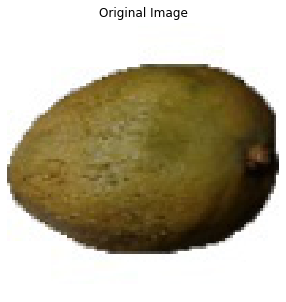

In [55]:
# visualize one of the original image of a fruit #
frt_orig = imread(sample_image_path)
plt.imshow(frt_orig)
plt.axis('off')
plt.title('Original Image');

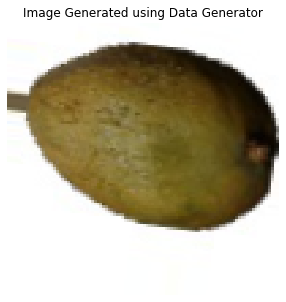

In [57]:
# visualize one the randomly generated image by the image generator of the same fruit #
plt.imshow(image_gen.random_transform(frt_orig))
plt.axis('off')
plt.title('Image Generated using Data Generator');

### Generating many manipulated images from directory

In [58]:
image_gen.flow_from_directory(TRAIN_PATH)

Found 16854 images belonging to 33 classes.


## Model Creation

***Use combination of Covolutional, Pooling Layer and finally Dense Layer***

In [7]:
# import the libraries #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout
from tensorflow import keras

***Conv --> Pool--> Conv--> Pool--> Conv--> Pool--> Flatten--> Dense--> Dense--> Dropout--> Final Dense Output***

In [105]:
# clear the session #
keras.backend.clear_session()
np.random.seed(42)

In [106]:
# create a sequential model #
model = Sequential()

# convolutional and max pool layer #
model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',strides=(1,1),
                activation='relu',input_shape=IMAGE_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2)))

# flatten the layer before feeding into the dense layer #
model.add(Flatten())

# dense layer together with dropout to prevent overfitting #
model.add(Dense(units=128,activation='relu',kernel_initializer='he_normal'))
model.add(Dense(units=64,activation='relu',kernel_initializer='he_normal'))

# turn off 50% of the neurons before passing onto the final layer #
model.add(Dropout(0.5))

# there are 33 classes, hence 33 neurons in the final layer #
model.add(Dense(units=33,activation='softmax'))

# compile the model #
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [107]:
# check the model summary # 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [108]:
model.layers

## Early Stopping

In [109]:
# import early stopping and model checkpoint #
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [110]:
early_stop = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

## Data for training the Model

In [31]:
BATCH_SIZE = 16
IMAGE_SHAPE[:2]

(100, 100)

***Train Image***

In [33]:
train_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical',seed=1,subset='training')

Found 11810 images belonging to 33 classes.


***Validation Image***

In [35]:
validation_image_gen = image_gen.flow_from_directory(TRAIN_PATH,target_size=IMAGE_SHAPE[:2],
                                               color_mode='rgb',batch_size=BATCH_SIZE,
                                               class_mode='categorical', shuffle=False,subset='validation',
                                               seed=1)

Found 5044 images belonging to 33 classes.


In [114]:
# check the class indices #
train_image_gen.class_indices

{'Apple Braeburn': 0,
 'Apple Granny Smith': 1,
 'Apricot': 2,
 'Avocado': 3,
 'Banana': 4,
 'Blueberry': 5,
 'Cactus fruit': 6,
 'Cantaloupe': 7,
 'Cherry': 8,
 'Clementine': 9,
 'Corn': 10,
 'Cucumber Ripe': 11,
 'Grape Blue': 12,
 'Kiwi': 13,
 'Lemon': 14,
 'Limes': 15,
 'Mango': 16,
 'Onion White': 17,
 'Orange': 18,
 'Papaya': 19,
 'Passion Fruit': 20,
 'Peach': 21,
 'Pear': 22,
 'Pepper Green': 23,
 'Pepper Red': 24,
 'Pineapple': 25,
 'Plum': 26,
 'Pomegranate': 27,
 'Potato Red': 28,
 'Raspberry': 29,
 'Strawberry': 30,
 'Tomato': 31,
 'Watermelon': 32}

## Train the Model

In [115]:
# fit the model and train for 20 epochs with early stop enabled #
history=model.fit(train_image_gen,
                  validation_data = validation_image_gen,
                  epochs = 20,callbacks=[early_stop])

Epoch 1/20
739/739 [==============================] - 179s 242ms/step - loss: 1.8201 - acc: 0.4251 - val_loss: 0.3845 - val_acc: 0.8682
Epoch 2/20
739/739 [==============================] - 179s 242ms/step - loss: 0.5508 - acc: 0.8069 - val_loss: 0.2136 - val_acc: 0.9280
Epoch 3/20
739/739 [==============================] - 179s 242ms/step - loss: 0.3624 - acc: 0.8727 - val_loss: 0.2070 - val_acc: 0.9193
Epoch 4/20
739/739 [==============================] - 182s 246ms/step - loss: 0.2831 - acc: 0.9029 - val_loss: 0.0959 - val_acc: 0.9651
Epoch 5/20
739/739 [==============================] - 172s 232ms/step - loss: 0.2616 - acc: 0.9133 - val_loss: 0.1381 - val_acc: 0.9504
Epoch 6/20
739/739 [==============================] - 173s 234ms/step - loss: 0.2174 - acc: 0.9278 - val_loss: 0.0431 - val_acc: 0.9831
Epoch 7/20
739/739 [==============================] - 182s 247ms/step - loss: 0.1749 - acc: 0.9406 - val_loss: 0.0619 - val_acc: 0.9792
Epoch 8/20
739/739 [============================

In [116]:
# save the trained model #
#model.save('kaggle_nmlo_4_cnn.h5')

In [2]:
# load the saved model #
from tensorflow.keras.models import load_model
nmlo_model = load_model('kaggle_nmlo_4_cnn.h5')

W0819 18:05:08.767668 139872013215552 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 18:05:08.769864 139872013215552 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0819 18:05:08.771569 139872013215552 deprecation.py:506] From /usr/local/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.pyt

In [122]:
nmlo_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [131]:
# create dataframe of the loss and accuracy of the train and validation data #
df_loss = pd.DataFrame(model.history.history)

In [129]:
df_loss.head()

,loss,acc,val_loss,val_acc
0,1.819849,0.425063,0.384508,0.868160
1,0.550192,0.806859,0.213639,0.928033
2,0.361661,0.872735,0.206997,0.919310
3,0.282565,0.902879,0.095878,0.965107
4,0.261380,0.913294,0.138081,0.950436


In [130]:
df_loss.tail()

,loss,acc,val_loss,val_acc
15,0.076203,0.976461,0.011851,0.997819
16,0.072653,0.978662,0.226252,0.965900
17,0.094106,0.973412,0.007214,0.998216
18,0.085204,0.976799,0.016223,0.995242
19,0.052664,0.984674,0.007611,0.997621


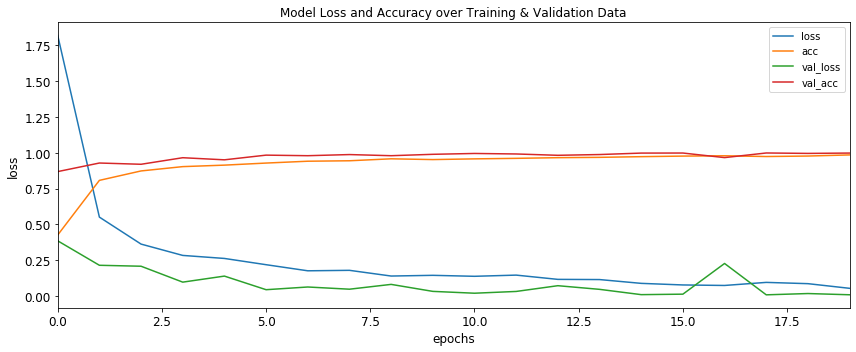

In [138]:
df_loss[['loss','acc','val_loss','val_acc']].plot()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Loss and Accuracy over Training & Validation Data');
save_figures('Model Loss')

In [137]:
model.evaluate(validation_image_gen)

316/316 [==============================] - 32s 102ms/step - loss: 0.0053 - acc: 0.9986


[0.005310772990167581, 0.9986122]

## Prediction on the unseen test images

In [8]:
model = load_model('kaggle_nmlo_4_cnn.h5')

In [9]:
test_image_gen = ImageDataGenerator(rescale=1./255)    

In [15]:
TEST_PATH

'../cloudxlab_jupyter_notebooks/datasets/Kaggle/test/'

In [26]:
test_generator = test_image_gen.flow_from_directory(directory=TEST_PATH,
                                                 target_size=IMAGE_SHAPE[:2],
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=None,
                                                  shuffle=False)

Found 5641 images belonging to 1 classes.


In [27]:
pred = model.predict(test_generator,steps=len(test_generator),verbose=1)

353/353 [==============================] - 22s 63ms/step


In [28]:
predicted_class_indices=np.argmax(pred,axis=1)

In [36]:
labels = (train_image_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [37]:
# get filenames 
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [38]:
results.tail()

,Filename,Predictions
5636,test/5636.jpg,Mango
5637,test/5637.jpg,Grape Blue
5638,test/5638.jpg,Blueberry
5639,test/5639.jpg,Apricot
5640,test/5640.jpg,Passion Fruit


In [39]:
results.head(10)

,Filename,Predictions
0,test/0000.jpg,Apricot
1,test/0001.jpg,Grape Blue
2,test/0002.jpg,Mango
3,test/0003.jpg,Grape Blue
4,test/0004.jpg,Mango
5,test/0005.jpg,Watermelon
6,test/0006.jpg,Apricot
7,test/0007.jpg,Mango
8,test/0008.jpg,Grape Blue
9,test/0009.jpg,Potato Red


In [40]:
df_submission = results.drop('Filename',axis=1)

In [41]:
df_submission['id'] = df_submission.index

In [42]:
df_submission.columns = ['label','id']

In [43]:
df_submission = df_submission[['id','label']]

In [44]:
df_submission.head()

,id,label
0,0,Apricot
1,1,Grape Blue
2,2,Mango
3,3,Grape Blue
4,4,Mango


In [45]:
# save the results into a csv file as per the submission guideline #
df_submission.to_csv('nmlo_4_cnn_prakhar_submission.csv',index=False)